# Analysis of Salary Requirements and Inflation (2018–2025)

## Introduction

The Finnish Immigration Service (Migri) updates the minimum salary requirements annually. For individuals and organizations affected by these changes, staying informed about trends and predictions is crucial.

This notebook analyzes salary requirements for various residence permits, such as the Specialist, or the EU Blue Card, alongside inflation data in Finland from 2018 to 2025. The goal is to uncover trends and provide a foundation for forecasting future salary requirements.

### Import libraries and setup

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Load Minimum Salary Data (2018-2025)

In [5]:
min_salaries_file_path = '../data/migri_residence_premit_salary_requirements_2018_2025.csv'
min_salaries_df = pd.read_csv(min_salaries_file_path)
min_salaries_df['archive_date'] = pd.to_datetime(min_salaries_df['archive_date'], format='%d.%m.%Y')

In [6]:
print("Data Preview:")
min_salaries_df.sample(5)

Data Preview:


,archive_date,year,amount,type,archive_url
25,2018-01-29,2018,4578,eu-n-sininenkortti,https://web.archive.org/web/20180129000845/htt...
14,2023-01-15,2023,5209,eu-n-sininenkortti,https://web.archive.org/web/20230115093315/htt...
23,2019-01-14,2019,4732,eu-n-sininenkortti,https://web.archive.org/web/20190114205503/htt...
15,2022-12-07,2022,5069,eu-n-sininenkortti,https://web.archive.org/web/20221207174531/htt...
31,2020-05-11,2020,1236,tyontekijan-oleskelulupa,https://web.archive.org/web/20200511075353/htt...


In [7]:
# Dictionary for translation
translation_dict = {
    'tyontekijan-oleskelulupa': 'Residence permit application for an employed person (TTOL)',
    'erityisasiantuntija': 'Specialist',
    'eu-n-sininenkortti': 'EU Blue Card'
}

# Add the new column with translations
min_salaries_df['type_en'] = min_salaries_df['type'].map(translation_dict)

min_salaries_df.sample(5)

,archive_date,year,amount,type,archive_url,type_en
4,2022-01-28,2022,3000,erityisasiantuntija,https://web.archive.org/web/20220128055917/htt...,Specialist
25,2018-01-29,2018,4578,eu-n-sininenkortti,https://web.archive.org/web/20180129000845/htt...,EU Blue Card
33,2028-02-26,2018,1189,tyontekijan-oleskelulupa,https://web.archive.org/web/20180527164253/htt...,Residence permit application for an employed p...
9,2025-01-04,2025,3827,eu-n-sininenkortti,https://web.archive.org/web/20250104220144/htt...,EU Blue Card
5,2021-02-28,2021,3000,erityisasiantuntija,https://web.archive.org/web/20210228131909/htt...,Specialist


In [8]:
print("\nData Information:")
min_salaries_df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   archive_date  34 non-null     datetime64[ns]
 1   year          34 non-null     int64         
 2   amount        34 non-null     int64         
 3   type          34 non-null     object        
 4   archive_url   34 non-null     object        
 5   type_en       34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.7+ KB


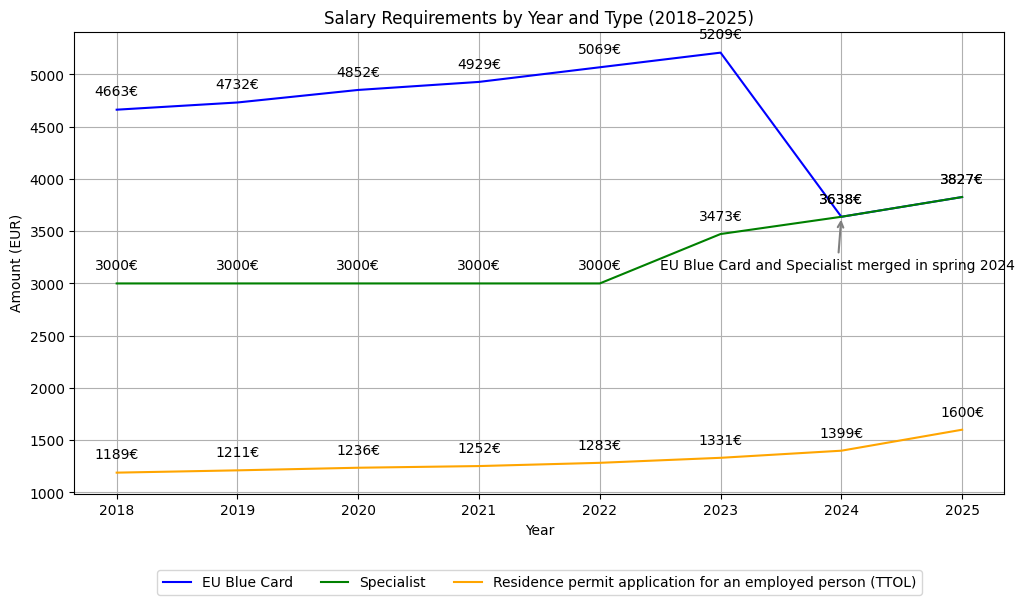

In [9]:
# Sort by year and archive_date to get the latest entry for each year
latest_salaries_df = min_salaries_df.sort_values(by=['year', 'archive_date'], ascending=[True, False]).drop_duplicates(subset=['year', 'type'])

# Define colors for each type
colors_dic = {
    'EU Blue Card': 'blue',
    'Specialist': 'green',
    'Residence permit application for an employed person (TTOL)': 'orange'
}

# Plot the data
plt.figure(figsize=(12, 6))
for key, grp in latest_salaries_df.groupby('type_en'):
    plt.plot(grp['year'], grp['amount'], label=key, color=colors_dic[key])
    for _, row in grp.iterrows():
        plt.annotate(f"{row['amount']}€", (row['year'], row['amount']), textcoords="offset points", xytext=(0,10), ha='center')

for _, row in latest_salaries_df.iterrows():
    if row['year'] == 2024 and row['type_en'] == 'Specialist':
        plt.annotate(f"EU Blue Card and Specialist merged in spring 2024",
                     xy=(row['year'], row['amount']),
                     xytext=(row['year'] - 1.5, row['amount'] - 500),
                     arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'))

plt.xlabel('Year')
plt.ylabel('Amount (EUR)')
plt.title('Salary Requirements by Year and Type (2018–2025)')

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index('EU Blue Card'), labels.index('Specialist'), labels.index('Residence permit application for an employed person (TTOL)')]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.grid(True)
plt.show()

## Part 2. Load Consumer Price Index Data (2018-2024)

The Consumer Price Index (CPI) tracks the average change over time in the prices paid by consumers for a basket of goods and services. It is a key indicator of inflation, used to assess changes in purchasing power and the cost of living. The CPI is calculated by comparing current prices to those in a base year, set to an index value of 100.

In this analysis, CPI data from Statistics Finland is gathered via their API using a Python script located at `scripts/consumer_price_index_query.py`. The data covers monthly CPI values for 2018 to 2024, based on a fixed index (2015 = 100). The results are saved in `data/consumer_price_index.csv` for further processing. By aggregating monthly data, annual averages are calculated to enable consistent comparisons across years and assess inflation trends.

In [10]:
import subprocess

# Call the script to get fresh CPI data
subprocess.run(['python', '../scripts/consumer_price_index_query.py'])

CompletedProcess(args=['python', '../scripts/consumer_price_index_query.py'], returncode=1)

In [11]:
cpi_file_path = '../data/consumer_price_index.csv'
cpi_df = pd.read_csv(cpi_file_path)
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
cpi_df['Year'] = cpi_df['Date'].dt.year
cpi_df = cpi_df[cpi_df['Year'] >= 2018]
cpi_df.info()
cpi_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 36 to 118
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    83 non-null     datetime64[ns]
 1   CPI     83 non-null     float64       
 2   Year    83 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 2.3 KB


,Date,CPI,Year
62,2020-03-01,103.49,2020
60,2020-01-01,103.32,2020
41,2018-06-01,102.32,2018
102,2023-07-01,121.30,2023
49,2019-02-01,102.80,2019


### Calculating Annual Consumer Price Index (CPI)

To calculate the **annual Consumer Price Index (CPI)** from the monthly data, I aggregate the CPI values for all 12 months of each year and compute their average. This is done using the following formula:

$$
\text{Annual CPI} = \frac{\sum \text{Monthly CPI}}{12}
$$

The steps are as follows:
1. Sum the monthly CPI values for each year.
2. Divide the total by 12 (the number of months in a year).

This approach accounts for seasonal variations in prices and ensures a consistent yearly CPI value, making it suitable for comparing inflation trends across years. 


In [12]:
annual_cpi_df = cpi_df.groupby('Year')['CPI'].mean().reset_index()
annual_cpi_df.columns = ['Year', 'Annual CPI']
display(annual_cpi_df)

,Year,Annual CPI
0,2018,102.204167
1,2019,103.250833
2,2020,103.550833
3,2021,105.823333
4,2022,113.361667
5,2023,120.447500
6,2024,122.328182


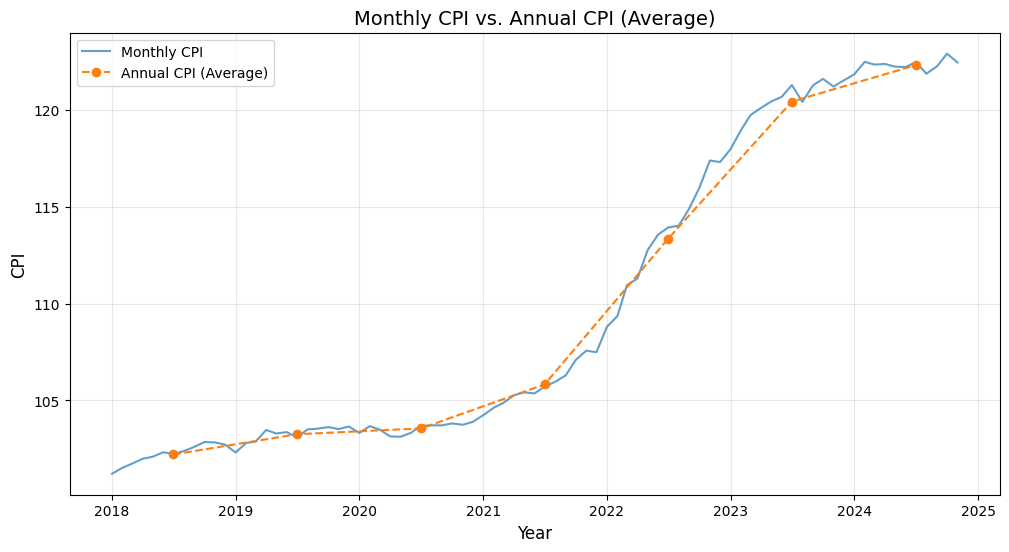

In [13]:
# Convert the 'Date' column in cpi_df to datetime if not already done
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot monthly CPI
plt.plot(cpi_df['Date'], cpi_df['CPI'], label='Monthly CPI', linestyle='-', alpha=0.7)

# Plot annual CPI (align to the middle of each year)
annual_cpi_df['Year_Mid'] = pd.to_datetime(annual_cpi_df['Year'].astype(str) + '-07-01')
plt.plot(annual_cpi_df['Year_Mid'], annual_cpi_df['Annual CPI'], label='Annual CPI (Average)', marker='o', linestyle='--')

# Add labels and legend
plt.title('Monthly CPI vs. Annual CPI (Average)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CPI', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


## Part 3. Matching Salary Requirements with Inflation Trends

Figure 3 - Annual CPI vs. Minimum Salary Requirements for Residence Permits (2015-2025)

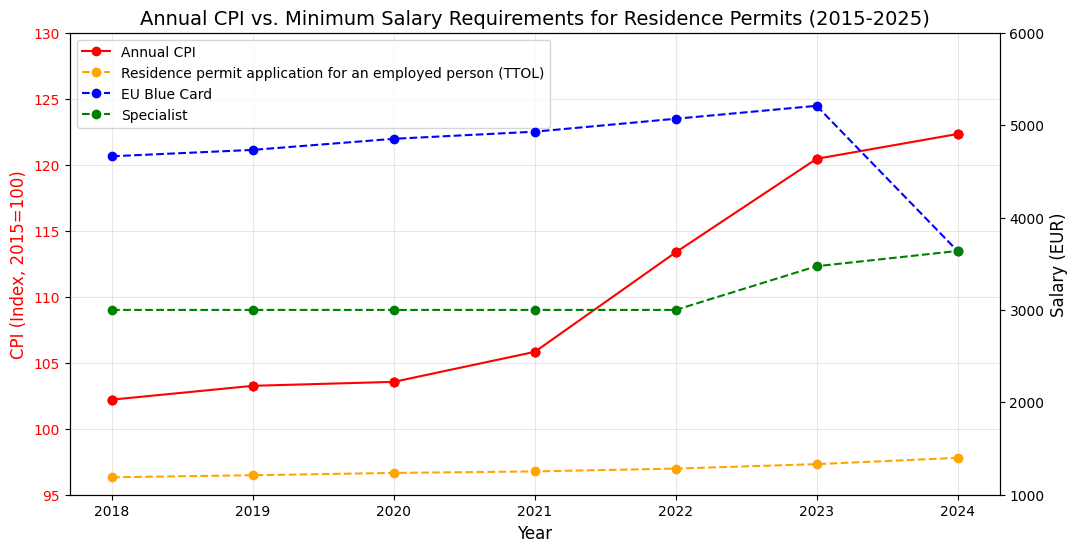

In [15]:
# Sort by year and archive_date to get the latest entry for each year and type
latest_salaries_df = min_salaries_df.sort_values(by=['year', 'archive_date'], ascending=[True, False])
latest_salaries_df = latest_salaries_df.drop_duplicates(subset=['year', 'type_en'])

# Merge the filtered salary data with annual CPI
merged_df = latest_salaries_df.merge(annual_cpi_df, left_on='year', right_on='Year')

# Create the figure and primary y-axis for CPI
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CPI on the left y-axis
ax1.plot(
    merged_df['Year'], merged_df['Annual CPI'],
    label='Annual CPI', marker='o', linestyle='-', color='red'
)
ax1.set_ylabel('CPI (Index, 2015=100)', fontsize=12, color='red')
ax1.set_xlabel('Year', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(95, 130)  # Adjust CPI range if necessary
ax1.grid(alpha=0.3)

# Secondary y-axis for salary data
ax2 = ax1.twinx()

# Define colors for each type
colors = {
    'EU Blue Card': 'blue',
    'Specialist': 'green',
    'Residence permit application for an employed person (TTOL)': 'orange'
}

# Plot latest salary data for each permit type
for permit_type in merged_df['type_en'].unique():
    permit_data = merged_df[merged_df['type_en'] == permit_type]
    if not permit_data.empty:  # Ensure there is data to plot
        ax2.plot(
            permit_data['year'], permit_data['amount'],
            label=f'{permit_type}', marker='o', linestyle='--', color=colors[permit_type]
        )

ax2.set_ylabel('Salary (EUR)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(1000, 6000)  # Adjust salary range as necessary

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

# Add title
plt.title('Annual CPI vs. Minimum Salary Requirements for Residence Permits (2015-2025)', fontsize=14)

# Show the plot
plt.show()


To adjust the salaries to the latest CPI value (2024-11), the following formula is applied:

$$
\text{Adjusted Amount} = \text{Original Amount} \times \left(\frac{\text{Latest CPI}}{\text{Annual CPI for Year}}\right)
$$

This formula scales the original salary amount by the ratio of the latest CPI to the annual CPI for each year, effectively expressing all salaries in terms of 2024-11 CPI, accounting for inflation.

In [16]:
# Adjusting each year salary to the latest CPI (2024-11)
latest_cpi = cpi_df.sort_values(by='Date').iloc[-1]['CPI']
print(f"Latest CPI (2024-11): {latest_cpi}")
merged_df['adjusted_amount'] = merged_df['amount'] * (latest_cpi / merged_df['Annual CPI'])
merged_df.sample(5)

Latest CPI (2024-11): 122.47


,archive_date,year,amount,type,archive_url,type_en,Year,Annual CPI,Year_Mid,CPI Growth,CPI Growth Rate,adjusted_amount
1,2018-12-14,2018,4663,eu-n-sininenkortti,https://web.archive.org/web/20181214215534/htt...,EU Blue Card,2018,102.204167,2018-07-01,NaN,NaN,5587.615736
18,2024-12-04,2024,3638,eu-n-sininenkortti,https://web.archive.org/web/20241204000843/htt...,EU Blue Card,2024,122.328182,2024-07-01,1.880682,-5.205152,3642.217626
8,2020-04-06,2020,3000,erityisasiantuntija,https://web.archive.org/web/20200406213111/htt...,Specialist,2020,103.550833,2020-07-01,0.300000,-0.746667,3548.112441
7,2020-05-11,2020,1236,tyontekijan-oleskelulupa,https://web.archive.org/web/20200511075353/htt...,Residence permit application for an employed p...,2020,103.550833,2020-07-01,0.300000,-0.746667,1461.822326
19,2024-03-04,2024,3638,erityisasiantuntija,https://web.archive.org/web/20240304082130/htt...,Specialist,2024,122.328182,2024-07-01,1.880682,-5.205152,3642.217626


### Figure 4 - Annual CPI vs. Adjusted Minimum Salary Requirements for Residence Permits (2015-2025)

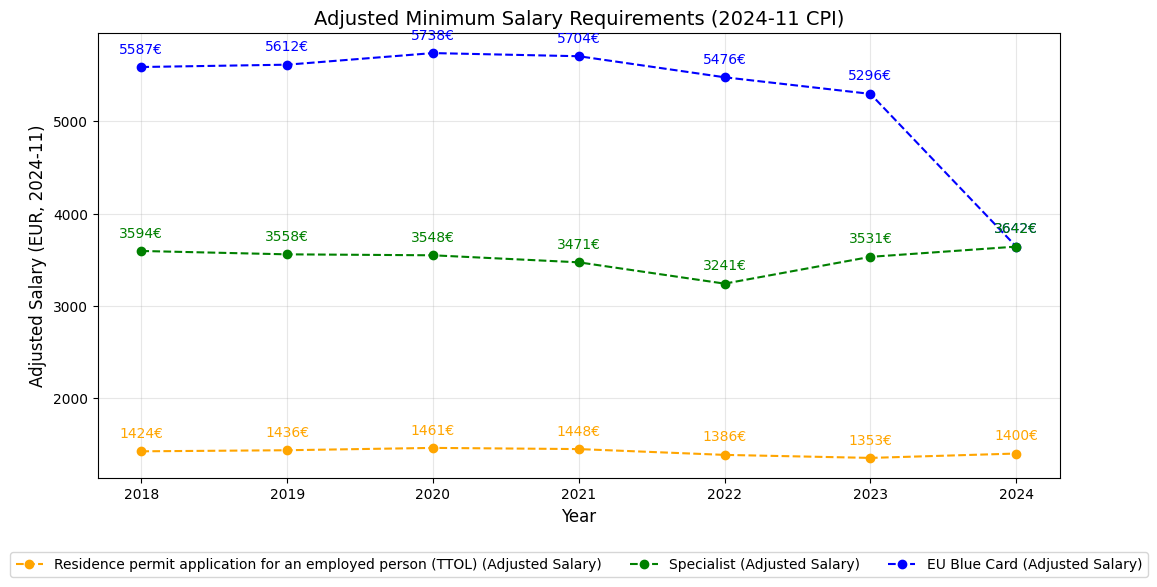

In [ ]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 6))

# Plot adjusted salary lines for each permit type
for permit_type in merged_df['type_en'].unique():
    permit_data = merged_df[merged_df['type_en'] == permit_type]
    if not permit_data.empty:  # Ensure there is data to plot
        plt.plot(
            permit_data['year'], permit_data['adjusted_amount'],
            label=f'{permit_type} (Adjusted Salary)', marker='o', linestyle='--', color=colors.get(permit_type, 'gray')
        )
        # Annotate each point
        for _, row in permit_data.iterrows():
            plt.annotate(
                f"{int(row['adjusted_amount'])}€",  # Format as integer with €
                (row['year'], row['adjusted_amount']),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color=colors.get(permit_type, 'gray')
            )

# Add labels and legend
plt.title('Adjusted Minimum Salary Requirements (Based on 2024-11 CPI)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adjusted Salary (EUR, 2024-11)', fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.grid(alpha=0.3)

# Adjust x and y limits if needed
plt.xticks(merged_df['year'].unique())
plt.tight_layout()

# Show the plot
plt.show()
